In [1]:
#Importamos las librerias para ejecutar instrucciones
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.random as nrd
import random

In [2]:
#Mandamos a llamar a drive donde tenemos guardado nuestra base de datos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Cargamos la base de datos
DF = pd.read_csv('/content/drive/MyDrive/PracticasProfesionales/Analisis_de_cuentas.csv')

# **Modificaciones**

In [4]:
#Retiramos una columna
DF.drop(DF.index[-6:],axis = 0, inplace = True)

In [5]:
#Volvemos binaria la variable status generado de datos
DF = DF.replace({'status_generado': {'RECHAZADO': 0, 'APROBADO': 1}})

In [6]:
historico = DF.iloc[:,-1]
#crear una serie booleana donde true indica que el historico de pagos está saldado a la fecha
mask = historico.str[1] == 'V'
mask = mask.astype(int)
DF.iloc[:,-1] = mask

<ipython-input-6-d9961aab80cc>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  DF.iloc[:,-1] = mask


In [7]:
#Retiramos las variables que evitan que la regresion converja
DF.drop('creditosIntegranteSubsidiadoParaEvitarMora',axis = 1, inplace = True)
DF.drop('creditosConvenioDeFiniquito',axis = 1, inplace = True)

In [8]:
#Eliminamos duplicados
DF = DF.drop_duplicates()

In [9]:
#Guardamos nombres de columnas para hacer la limpieza de datos
cols = ['atrasos', 'emprende_cerrados',  'posiblesCreditosCerrados', 'edad',
        'otrosCreditosParaAnalizar',  'quebrantos',  'consultas', 'cuentas_activas']

In [10]:
#Limpiamos datos con el metodo inter cuartil
for i in cols:
    x1 = DF[i].quantile(0.25)
    x2 = DF[i].quantile(0.75)

    I = x2 - x1

    lower_bound = x1 - 1.5 * I
    upper_bound = x2 + 1.5 * I

    DF = DF[((DF[i] >= lower_bound) & (DF[i] <= upper_bound))]

In [11]:
#Retiramos las variables que no son indispensables
DF.drop('otrosCreditosParaAnalizar',axis = 1, inplace = True)
DF.drop('creditosAbiertosQuebrantosNoCerrados',axis = 1, inplace = True)
DF.drop('domicilios',axis = 1, inplace = True)
DF.drop('creditosAbiertos',axis = 1, inplace = True)
DF.drop('creditosCedidoAUnTercero',axis = 1, inplace = True)

# **Red neuronal**

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [13]:
#Retiramos variables que no le permiten converger al modelo
X = DF.drop({'sucursal', 'nombre', 'fecha_de_consulta', 'status_generado'},axis =1)
y = DF["status_generado"]

In [14]:
X = X.values
y = y.values

In [15]:
#Separamos en conjunto de testeo y de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [17]:
#Standarizamos datos de entrenamiento y testeo (variables independientes)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
scaler.fit_transform(X_train)
scaler.fit_transform(X_test)

array([[-0.12121534, -0.12638917, -0.16651155, ..., -0.36442524,
        -0.20130983,  0.38708093],
       [-0.12121534, -0.50806305,  1.54367475, ..., -0.36442524,
        -1.03575988,  0.38708093],
       [-0.12121534,  0.76798094, -1.0216047 , ..., -0.36442524,
         0.63314023,  0.38708093],
       ...,
       [-0.12121534,  0.42048682, -0.16651155, ..., -0.36442524,
        -0.50474621,  0.38708093],
       [-0.12121534, -0.3599508 , -0.16651155, ..., -0.36442524,
        -1.26333717,  0.38708093],
       [-0.12121534,  0.36352057, -1.0216047 , ..., -0.36442524,
        -0.88404169,  0.38708093]])

In [18]:
#Importamos mas librerias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [19]:
#Elegimos hiperparametros, Tamaño de batch 76, 1000 epocas para entrenar
#Optimizador Adam para evitar sobresaturación y función de costo
#Binary crossentropy porque el resultado debe ser decision binaria
parameters = {
    "batch_size": 76,
    "epochs": 1000,
    "optimizer": "Adam",
    "loss": "binary_crossentropy",
}

In [20]:
#Se crea un modelo secuencial, es decir, cada neurona de cada capa
#Esta conectada a cada neurona de la siguiente capa
model = Sequential()
#Primera capa, espera recibir vectores de 19 características
model.add(Input(shape=(19,)))
#2 capas ocultas, cada una con 76 neuronas, funciones de activacion tanh
# y regularizadores L1 y L2 para evitar saturación
model.add(Dense(76, activation='tanh', kernel_regularizer=regularizers.L1L2(l1 = 1e-4, l2=1e-3))) #Regularizacion L1L2
model.add(Dense(76, activation='tanh', kernel_regularizer=regularizers.L1(l1 = 1e-4))) #Regularizacion L1
#Capa de salida con una neurona que tiene activacion sigmoide
model.add(Dense(1, activation='sigmoid'))  # Capa de salida con una neurona y función de activación sigmoide
#Reporte general del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 76)                1520      
                                                                 
 dense_1 (Dense)             (None, 76)                5852      
                                                                 
 dense_2 (Dense)             (None, 1)                 77        
                                                                 
Total params: 7449 (29.10 KB)
Trainable params: 7449 (29.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
#Ajustamos el modelo para que evalue accuracy
#Learning_rate = 0.00015
#Y utilice optimizador Adam para evitar sobre saturacion
model.compile(loss=parameters['loss'],optimizer = Adam(learning_rate=0.00015),metrics=['accuracy'])

In [22]:
#Si despues de 40 epocas el modelo no mejora, se detiene el aprendizaje y se devuelve la mejor epoca que tuvo
early_stopping = EarlyStopping(monitor='val_loss', patience=40, verbose=1, restore_best_weights=True)

In [23]:
#Se ajusta el modelo para que entrene con nuestros datos de entrenamiento
# e hiperparametros que definimos anteriormetne
history = model.fit(X_train, y_train,
                    batch_size=parameters['batch_size'],
                    epochs=parameters["epochs"],
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[early_stopping]
                    )

Epoch 1/1000
58/58 [==============================] - 1s 7ms/step - loss: 0.7148 - accuracy: 0.6796 - val_loss: 0.5939 - val_accuracy: 0.8307
Epoch 2/1000
58/58 [==============================] - 0s 3ms/step - loss: 0.5486 - accuracy: 0.8281 - val_loss: 0.4980 - val_accuracy: 0.8618
Epoch 3/1000
58/58 [==============================] - 0s 4ms/step - loss: 0.4828 - accuracy: 0.8508 - val_loss: 0.4527 - val_accuracy: 0.8692
Epoch 4/1000
58/58 [==============================] - 0s 5ms/step - loss: 0.4475 - accuracy: 0.8629 - val_loss: 0.4251 - val_accuracy: 0.8728
Epoch 5/1000
58/58 [==============================] - 0s 5ms/step - loss: 0.4252 - accuracy: 0.8693 - val_loss: 0.4073 - val_accuracy: 0.8783
Epoch 6/1000
58/58 [==============================] - 0s 5ms/step - loss: 0.4101 - accuracy: 0.8725 - val_loss: 0.3940 - val_accuracy: 0.8829
Epoch 7/1000
58/58 [==============================] - 0s 5ms/step - loss: 0.3989 - accuracy: 0.8778 - val_loss: 0.3844 - val_accuracy: 0.8866
Epoch 

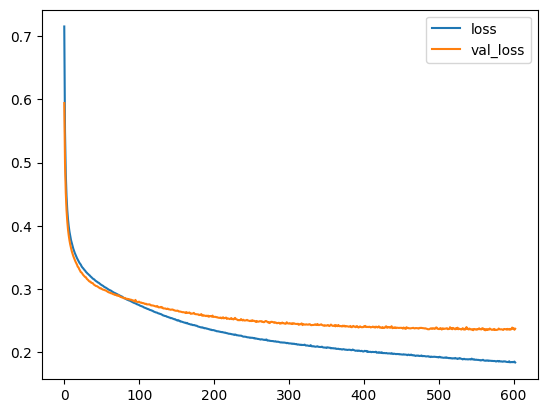

In [24]:
#Graficamos la medicion de loss
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()

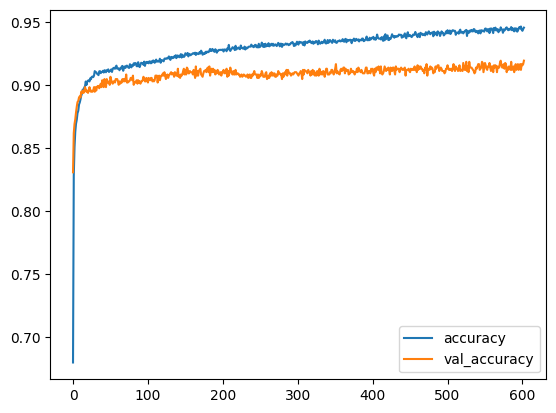

In [25]:
#Graficamos la medicion de accuracy
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()

In [26]:
#Imprimimos las evaluaciones
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

43/43 [==============================] - 0s 2ms/step - loss: 0.2394 - accuracy: 0.9158
Loss: 0.23935745656490326
Accuracy: 0.915812611579895


43/43 [==============================] - 0s 2ms/step


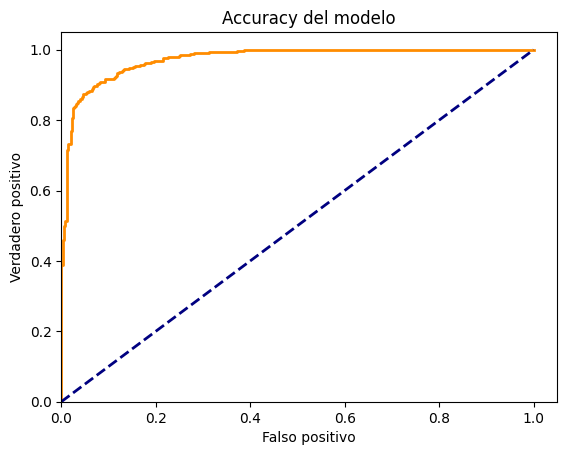

Matriz de Confusión:
[[398  54]
 [ 61 853]]


In [27]:
#Descargamos librerias para graficar
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

#Predecir clases y probabilidades
y_pred_probs = model.predict(X_test)

# Curva ROC
f, t, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(f, t)

#Graficamos la curva
plt.figure()
plt.plot(f, t, color='darkorange', lw=2, label='Curva de Roc (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso positivo')
plt.ylabel('Verdadero positivo')
plt.title('Accuracy del modelo')
plt.show()

# Matriz de confusión
y_pred_classes = np.round(y_pred_probs)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Matriz de Confusión:")
print(conf_matrix)

